In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import re
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf

## Word2Vec with CNN
Each word will tranform by pretrained model to vector in size 300 so each instance is atually a matrix

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import re
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tfa

In [10]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"

In [11]:
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [12]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [2]:
import gensim.downloader
#glove-twitter-200
glove_vectors = gensim.downloader.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [3]:
import swifter
import re
import nltk
MAX_NUMBER_OF_WORDS = 50
ENCODE_SIZE = 50

def get_vector(word):
    try:
        return glove.get_vector(word)
    except:
        pass
    return np.zeros((ENCODE_SIZE,))

def precoess_row(text):
    vec = np.array([get_vector(word) for word in nltk.word_tokenize(re.sub(r'\d+', '', text))])
    if vec.shape[0] >= MAX_NUMBER_OF_WORDS:
        vec = vec[:MAX_NUMBER_OF_WORDS,:]
    else:
        vec = np.vstack((vec,np.zeros((MAX_NUMBER_OF_WORDS-vec.shape[0],ENCODE_SIZE))))
    return vec

In [ ]:
df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].swifter.apply(precoess_row)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [4]:
from sklearn.model_selection import train_test_split
X,y = df['Text'],df[LABEL_COLUMN_NAME]
x_train,x_test, y_train,y_test = train_test_split(X,y, test_size=0.30, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.50, random_state=42)

NameError: name 'df' is not defined

{0: 0.26771, 1: 0.73229}


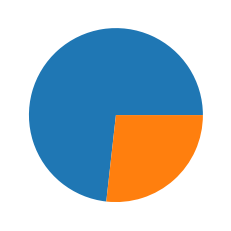

In [14]:
plt.pie(y.value_counts())
x_neg_weight = y[y==1].shape
x_pos_weight = y[y==0].shape
x_neg_weight[0]/x_pos_weight[0]
weights = {0: (x_neg_weight[0]/(x_pos_weight[0]+x_neg_weight[0])),1: (x_pos_weight[0]/(x_pos_weight[0]+x_neg_weight[0]))}
print(weights)

In [32]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,MaxPool1D,Flatten,Conv2D,Dropout,MaxPooling2D
model = Sequential()
model.add(Conv2D(10,(5,1), use_bias=True,padding="valid",input_shape=(2000,300,1)))
model.add(MaxPooling2D(pool_size=(5,1),padding='valid'))
model.add(Conv2D(1,(10,1), use_bias=True,padding="valid",input_shape=(2000,300,1)))
model.add(MaxPooling2D(pool_size=(10,1),padding='valid'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 1996, 300, 10)     60        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 399, 300, 10)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 390, 300, 1)       101       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 39, 300, 1)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 300, 1)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 11700)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)             

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(x_train,y_train,batch_size=200,epochs=500,
                    validation_split=0.05,class_weight=weights.to_dict(),
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[])

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

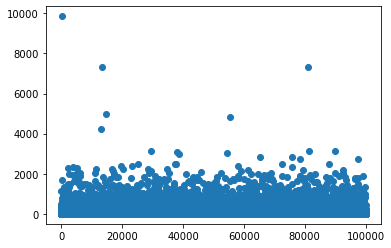

In [62]:
plt.scatter(list(range(df.shape[0])),df["Text"].swifter.apply(lambda text: len(nltk.word_tokenize(text))).values)

In [58]:
model = Sequential()
model.add(Bidirectional(LSTM(48,recurrent_dropout=0.5),input_shape=(200,1)))
model.add(Dense(24, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 96)                19200     
_________________________________________________________________
dense_37 (Dense)             (None, 24)                2328      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 25        
Total params: 21,553
Trainable params: 21,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(x_train.squeeze(),y_train,batch_size=200,epochs=100,
                    validation_split=0.05,class_weight=weights.to_dict(),
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])